In [13]:
import pandas as pd
from groq import Groq
from pathlib import Path
from dotenv import get_variables
from graph.graph import ArticleGraph
from config.config import read_yaml_file
from data.scraper import google_news_articles, scrape_url
from data.wrangler import obtain_topics_and_person, summarize_text
from text_analysis.utils import contains_any_word, if_contains_assign, evaluate_string, extract_inside_braces

In [16]:
SOURCE_DIR = Path.cwd().parent
SERPAPI_KEY = get_variables(SOURCE_DIR /'.env')['SERPAPI_KEY']
GROQ_API_KEY = get_variables(SOURCE_DIR /'.env')['GROQ_API_KEY']
sources = read_yaml_file(SOURCE_DIR / "config/config_scraper.yaml")['sources']
topics = read_yaml_file(SOURCE_DIR / "config/config_scraper.yaml")['topics']
scrape_new_data = False
graph_config_path = SOURCE_DIR / "config/config_graph.json"

In [17]:
master_table = pd.read_csv(SOURCE_DIR / "datasets/elezioni_europee.csv")
master_table['source'] = master_table['source'].apply(eval)

In [20]:
keywords = ['Repubblica',
 'Corriere',
 'Foglio',
 'Giornale',
 'Carlino',
 'Stampa',
 'Quotidiano',
 'Sole',
 'Avvenire',
 'Mattino',
 'Messaggero',
 'Unitá',
 'Nazione',
 'Manifesto',
 'Nazionale',
 'Pagella']

In [21]:
if scrape_new_data:
    df = pd.DataFrame()
    for s in sources:
        df_t = google_news_articles(api_key=SERPAPI_KEY,
                                    keywords=f"{s} elezioni europee")
        df = pd.concat([df, df_t]).reset_index(drop=True)

    df = pd.concat([master_table, df]).drop_duplicates(subset='title').reset_index(drop=True)
    df.to_csv(SOURCE_DIR / "datasets/elezioni_europee.csv", index=False)

    df_tot = df[['title', 'source', 'link', 'date']]
    df_tot['source'] = df_tot['source'].apply(lambda x: x['name'])
    df_tot = df_tot[df_tot['source'].apply(contains_any_word, words=sources)].reset_index(drop=True)
    df_tot['source'] = df_tot['source'].apply(lambda row: if_contains_assign(row=row, words=sources, keywords=keywords))
    df_tot['text'] = df_tot['link'].apply(lambda url: scrape_url(url=url, clean_with_genai=False))
    df_tot['text_summary'] = df_tot['text'].apply(lambda text: summarize_text(text=text, api_key=GROQ_API_KEY))

else:
    df = master_table

/var/folders/7s/140yb8x92wj3r5nt6klj8k7w0000gn/T/ipykernel_27449/1838063047.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot['source'] = df_tot['source'].apply(lambda x: x['name'])


In [5]:
keywords = ['Repubblica',
 'Corriere',
 'Foglio',
 'Giornale',
 'Carlino',
 'Stampa',
 'Quotidiano',
 'Sole',
 'Avvenire',
 'Mattino',
 'Messaggero',
 'Unitá',
 'Nazione',
 'Manifesto',
 'Nazionale',
 'Pagella']

In [22]:
df_tot = df[['title', 'source', 'link', 'date']]
df_tot['source'] = df_tot['source'].apply(lambda x: x['name'])
df_tot['source'] = df_tot['source'].apply(lambda row: if_contains_assign(row=row,
                                                                         words=sources,
                                                                         keywords=keywords))
df_tot = df_tot.dropna(subset='source')

/var/folders/7s/140yb8x92wj3r5nt6klj8k7w0000gn/T/ipykernel_27449/2672331206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot['source'] = df_tot['source'].apply(lambda x: x['name'])
/var/folders/7s/140yb8x92wj3r5nt6klj8k7w0000gn/T/ipykernel_27449/2672331206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot['source'] = df_tot['source'].apply(lambda row: if_contains_assign(row=row,


In [23]:
df_tot['date'] = pd.to_datetime(df_tot['date'].apply(lambda x: x.split(',')[0]), format='%m/%d/%Y')
start_date = '2024-05-15'
end_date = '2024-06-09'
df_tot = df_tot[(df_tot['date'] >= pd.to_datetime(start_date)) & (df_tot['date'] <= end_date)]

In [26]:
print('Scraping URLs')
df_tot['text'] = df_tot['link'].apply(lambda url: scrape_url(url=url, clean_with_genai=False))
print('Summarizing texts')
df_tot = df_tot[df_tot['text'].astype(str).apply(len) < 15000].reset_index(drop=True)
df_tot['text_summary'] = df_tot['text'].apply(lambda text: summarize_text(text=text,
                                                                          api_key=GROQ_API_KEY,
                                                                          model="llama3-70b-8192"))
print('Extracting Topics & Person')
df_tot['topics_person'] = df_tot['text_summary'].apply(lambda text: obtain_topics_and_person(text=text,
                                                                                     api_key=GROQ_API_KEY,
                                                                                     topics_to_scrape=topics,
                                                                                     model="llama3-70b-8192"))

Scraping URLs
Request not successful
Summarizing texts
Extracting Topics & Person


In [27]:
df_tot.to_csv(SOURCE_DIR / "datasets/elezioni_europee_intermediate.csv", index=False)

In [28]:
df_tot['topics_person'] = df_tot['topics_person'].apply(extract_inside_braces).apply(evaluate_string)

Error evaluating expression 'None': eval() arg 1 must be a string, bytes or code object
Error evaluating expression 'None': eval() arg 1 must be a string, bytes or code object
Error evaluating expression 'None': eval() arg 1 must be a string, bytes or code object


In [29]:
df_tot.to_csv(SOURCE_DIR / "datasets/elezioni_europee_intermediate.csv", index=False)

In [28]:
df_tot.head()

,title,source,link,date,text,text_summary,topics_person
0,Test sui partiti in lizza alle elezioni europe...,La Repubblica,https://www.repubblica.it/politica/2024/05/29/...,2024-05-29,Partiti elezioni europee 2024: il test per sco...,Italy will hold elections for the European Par...,"{'topic': 'politiche elettorali', 'persons': []}"
1,"Europee, sette i candidati ""impresentabili"" pe...",La Repubblica,https://www.repubblica.it/politica/2024/05/28/...,2024-05-28,"Europee, sette i candidati ""impresentabili"" pe...",Seven Italian politicians have been designated...,"{'topic': 'Criminalità e Sicurezza Pubblica', ..."
2,"Europee, lo sfottò di Calenda al 'tappo' di Sa...",La Repubblica,https://video.repubblica.it/dossier/video-elez...,2024-05-27,"Europee, lo sfottò di Calenda al ""tappo"" di Sa...","Carlo Calenda, a well-known Italian politician...","{'topic': 'Tensioni tra politici', 'persons': ..."
3,Verso le elezioni europee. Meloni vuole azzera...,La Repubblica,https://www.repubblica.it/economia/rubriche/ou...,2024-05-28,Verso le elezioni europee. Meloni vuole azzera...,"Giorgia Meloni, leader of Fratelli d'Italia, i...","{'topic': 'Politiche Ambientali', 'persons': [..."
4,Liliana Segre sulle elezioni Europee: “L’esito...,La Repubblica,https://milano.repubblica.it/cronaca/2024/05/2...,2024-05-28,Liliana Segre sulle elezioni Europee: âLâe...,Senatrice a vita Liliana Segre is worried abou...,"{'topic': '', 'persons': ['Liliana Segre']}"


In [ ]:
df_tot = df_tot[df_tot.topics_person != {}]

In [ ]:
df_tot['topic'] = df_tot['topics_person'].apply(lambda x: x['topic'])
df_tot['person'] = df_tot['topics_person'].apply(lambda x: x['persons'])

In [ ]:
df_tot = df_tot.reset_index(drop=True)

In [ ]:
df_tot = df_tot.explode('person')

In [ ]:
df_tot['newspaper'] = df_tot['source']

In [ ]:
df_tot.to_csv(SOURCE_DIR / "datasets/elezioni_europee_intermediate2.csv", index=False)

In [87]:
graph = ArticleGraph(df_tot, graph_config_path)

In [44]:
pd.read_csv(SOURCE_DIR / "datasets/elezioni_europee_intermediate.csv")


,title,source,link,date,text,text_summary,topics_person
0,Test sui partiti in lizza alle elezioni europe...,La Repubblica,https://www.repubblica.it/politica/2024/05/29/...,"05/29/2024, 11:27 AM, +0000 UTC",Partiti elezioni europee 2024: il test per sco...,The article presents a interactive test to hel...,"Here is the result:\n\n{\n ""topic"": ""Politi..."
1,"Europee, sette i candidati ""impresentabili"" pe...",La Repubblica,https://www.repubblica.it/politica/2024/05/28/...,"05/28/2024, 11:11 AM, +0000 UTC","Europee, sette i candidati ""impresentabili"" pe...",Europe's Antimafia Committee has identified se...,"{\n""topic"": ""Criminalità e Sicurezza Pubblica""..."
2,"Europee, lo sfottò di Calenda al 'tappo' di Sa...",La Repubblica,https://video.repubblica.it/dossier/video-elez...,"05/27/2024, 05:24 PM, +0000 UTC","Europee, lo sfottò di Calenda al ""tappo"" di Sa...","Europe, Carlo Calenda, a leader of the Italian...","{\n ""topic"": ""Euroscetticismo"",\n ""persons"":..."
3,Verso le elezioni europee. Meloni vuole azzera...,La Repubblica,https://www.repubblica.it/economia/rubriche/ou...,"05/28/2024, 10:06 PM, +0000 UTC",Verso le elezioni europee. Meloni vuole azzera...,The article discusses the election program of ...,"Here is the output in JSON format:\n\n{\n ""..."
4,Liliana Segre sulle elezioni Europee: “L’esito...,La Repubblica,https://milano.repubblica.it/cronaca/2024/05/2...,"05/28/2024, 10:29 AM, +0000 UTC",Liliana Segre sulle elezioni Europee: âLâe...,"Liliana Segre, a senator for life, expressed c...","{\n ""topic"": ""Diritti Umani e Civili"",\n ..."
...,...,...,...,...,...,...,...
1286,Guida alle elezioni regionali in Abruzzo,Pagella Politica,https://pagellapolitica.it/articoli/guida-elez...,"03/06/2024, 08:00 AM, +0000 UTC",Guida alle elezioni regionali in Abruzzo | Pag...,Guida alle elezioni regionali in Abruzzo\n\nIl...,Here is the JSON object with the main topic an...
1287,Guida alle elezioni regionali in Basilicata,Pagella Politica,https://pagellapolitica.it/articoli/guida-elez...,"04/18/2024, 07:00 AM, +0000 UTC",Guida alle elezioni regionali in Basilicata | ...,The article provides a guide to the regional e...,"Here is the output:\n\n{\n""topic"": ""Elezioni p..."
1288,A Cagliari il centrodestra cerca la rivincita ...,Pagella Politica,https://pagellapolitica.it/articoli/guida-elez...,"06/05/2024, 07:00 AM, +0000 UTC",A Cagliari il centrodestra cerca la rivincita ...,A Cagliari il centrodestra cerca la rivincita ...,"{\n""topic"": ""Elezioni comunali"",\n""persons"": [..."
1289,Renzi deve scegliere tra l’Arabia Saudita e il...,Pagella Politica,https://pagellapolitica.it/articoli/renzi-parl...,"02/19/2024, 08:00 AM, +0000 UTC",Renzi deve scegliere tra l’Arabia Saudita e il...,"Here is the summarized text:\n\nMatteo Renzi, ...",Here is the extracted information in JSON form...


/Users/filippopacinelli/news-mapping-eu-elections/venv/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


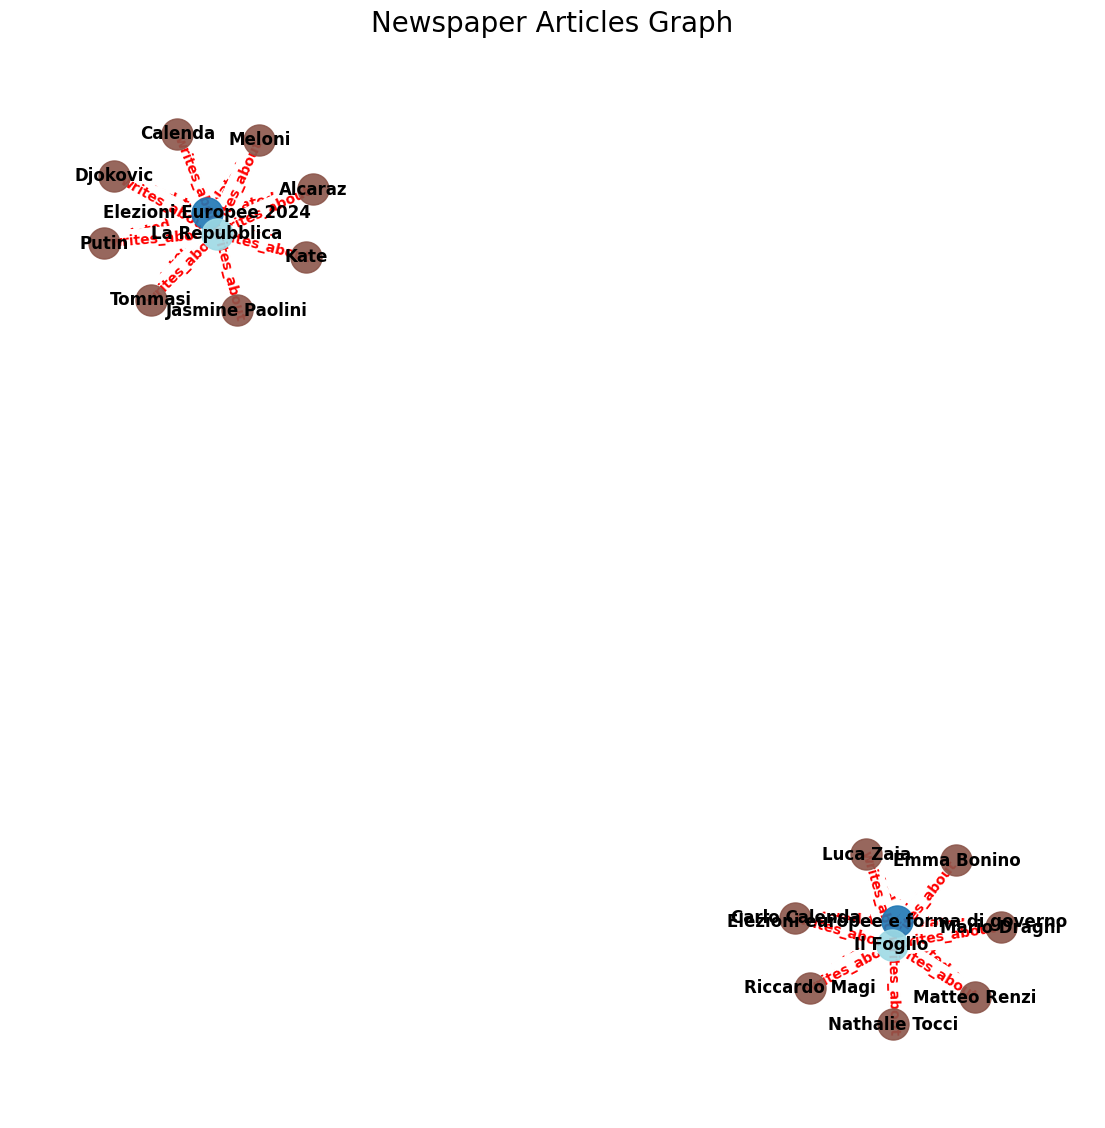

In [88]:
graph.plot_graph()

FileNotFoundError: [Errno 2] No such file or directory: 'Users/filippopacinelli/news-mapping-eu-elections/datasets/elezioni_europee_processed.csv'

In [20]:
df

,title,source,link,date,text,topics_person
0,"Votare per l’Europa, compito difficile ma dove...",Avvenire,https://www.avvenire.it/rubriche/pagine/votare...,"05/21/2024, 05:43 AM, +0000 UTC","Votare per l’Europa, compito difficile ma dove...",Here is the JSON output with the required info...
1,Alle Europee “cederemo” il voto ai nostri figl...,Avvenire,https://www.avvenire.it/attualita/pagine/cedia...,"05/24/2024, 08:03 PM, +0000 UTC",Alle Europee “cederemo” il voto ai nostri figl...,"Here is the JSON output:\n\n```\n{\n ""title..."
2,"Zuppi su premierato, autonomia differenziata, ...",Avvenire,https://www.avvenire.it/chiesa/pagine/conferen...,"05/23/2024, 02:06 PM, +0000 UTC","Zuppi su premierato, autonomia differenziata, ...","Here is the JSON output:\n\n```\n{\n ""title"":..."
3,"Meloni: ""Il referendum non passa? Chissene imp...",Avvenire,https://www.avvenire.it/attualita/pagine/premi...,"05/27/2024, 09:50 AM, +0000 UTC",Meloni: «Il referendum non passa? Chissene imp...,Here is the analyzed output in JSON format:\n\...
4,Un nuovo spettro si aggira per l'Europa: il «n...,Avvenire,https://www.avvenire.it/attualita/pagine/un-nu...,"04/02/2024, 07:00 AM, +0000 UTC",Un nuovo spettro si aggira per l'Europa: il «n...,Here is the JSON output with the requested inf...
...,...,...,...,...,...,...
118,Il Constitutional Circus sceglie Riace per lan...,Avvenire,https://www.avvenire.it/attualita/pagine/il-co...,"04/30/2024, 07:00 AM, +0000 UTC",Il Constitutional Circus sceglie Riace per lan...,"Here is the JSON output:\n\n```\n{\n ""title..."
119,"Soglia al 3%, un gioco del cerino in cui solta...",Avvenire,https://www.avvenire.it/attualita/pagine/un-gi...,"09/06/2023, 07:00 AM, +0000 UTC","Soglia al 3%, un gioco del cerino in cui solta...",Here is the analyzed news article in JSON form...
120,"Accoglienza e asilo, accordo fatto in Europa: ...",Avvenire,https://www.avvenire.it/attualita/pagine/patto...,"12/20/2023, 08:00 AM, +0000 UTC","Accoglienza e asilo, accordo fatto in Europa: ...",Here is the json object with the requested inf...
121,La via di Tommaso anche oggi: né appiattirsi n...,Avvenire,https://www.avvenire.it/opinioni/pagine/nell-o...,"05/04/2024, 07:00 AM, +0000 UTC",La via di Tommaso anche oggi: né appiattirsi n...,Here is the analyzed article in JSON format:\n...


In [18]:
df

,title,source,link,date,text,topics_person
0,"Votare per l’Europa, compito difficile ma dove...",Avvenire,https://www.avvenire.it/rubriche/pagine/votare...,"05/21/2024, 05:43 AM, +0000 UTC","Votare per l’Europa, compito difficile ma dove...",Here is the JSON output with the required info...
1,Alle Europee “cederemo” il voto ai nostri figl...,Avvenire,https://www.avvenire.it/attualita/pagine/cedia...,"05/24/2024, 08:03 PM, +0000 UTC",Alle Europee “cederemo” il voto ai nostri figl...,"Here is the JSON output:\n\n```\n{\n ""title..."
2,"Zuppi su premierato, autonomia differenziata, ...",Avvenire,https://www.avvenire.it/chiesa/pagine/conferen...,"05/23/2024, 02:06 PM, +0000 UTC","Zuppi su premierato, autonomia differenziata, ...","Here is the JSON output:\n\n```\n{\n ""title"":..."
3,"Meloni: ""Il referendum non passa? Chissene imp...",Avvenire,https://www.avvenire.it/attualita/pagine/premi...,"05/27/2024, 09:50 AM, +0000 UTC",Meloni: «Il referendum non passa? Chissene imp...,Here is the analyzed output in JSON format:\n\...
4,Un nuovo spettro si aggira per l'Europa: il «n...,Avvenire,https://www.avvenire.it/attualita/pagine/un-nu...,"04/02/2024, 07:00 AM, +0000 UTC",Un nuovo spettro si aggira per l'Europa: il «n...,Here is the JSON output with the requested inf...
...,...,...,...,...,...,...
118,Il Constitutional Circus sceglie Riace per lan...,Avvenire,https://www.avvenire.it/attualita/pagine/il-co...,"04/30/2024, 07:00 AM, +0000 UTC",Il Constitutional Circus sceglie Riace per lan...,"Here is the JSON output:\n\n```\n{\n ""title..."
119,"Soglia al 3%, un gioco del cerino in cui solta...",Avvenire,https://www.avvenire.it/attualita/pagine/un-gi...,"09/06/2023, 07:00 AM, +0000 UTC","Soglia al 3%, un gioco del cerino in cui solta...",Here is the analyzed news article in JSON form...
120,"Accoglienza e asilo, accordo fatto in Europa: ...",Avvenire,https://www.avvenire.it/attualita/pagine/patto...,"12/20/2023, 08:00 AM, +0000 UTC","Accoglienza e asilo, accordo fatto in Europa: ...",Here is the json object with the requested inf...
121,La via di Tommaso anche oggi: né appiattirsi n...,Avvenire,https://www.avvenire.it/opinioni/pagine/nell-o...,"05/04/2024, 07:00 AM, +0000 UTC",La via di Tommaso anche oggi: né appiattirsi n...,Here is the analyzed article in JSON format:\n...


In [ ]:
pd.read_csv('/Users/filippopacinelli/news-mapping-eu-elections/datasets/elezioni_europee_processed.csv')